<a href="https://colab.research.google.com/github/TINF-DeepfakeEvaluierung/Evaluation-von-Methoden-zur-Erkennung-von-Deepfakes/blob/main/LipForensic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/TINF-DeepfakeEvaluierung/LipForensics.git
%cd LipForensics
net_model = "LipForensic"

Cloning into 'LipForensics'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 142 (delta 73), reused 53 (delta 12), pack-reused 0
Receiving objects: 100% (142/142), 584.10 KiB | 8.59 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/LipForensics


In [ ]:
import sys
sys.path.append('..')

import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import deque
from collections import defaultdict
import pandas as pd
from sklearn import metrics
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop
import torch.nn.functional as F
from itertools import islice

from preprocessing.utils import warp_img, apply_transform, cut_patch

In [ ]:
# Connect Google Cloud
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "deepfake_detection_datasets"  # or a location like "my-bucket/path/to/mount"
local_path = f"/content/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0   9544      0 --:--:-- --:--:-- --:--:--  9530
OK
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up g

In [ ]:
!mkdir "./models/weights"
!cp "/content/deepfake_detection_datasets/LipForensic_model/lipforensics_ff.pth" "./models/weights"

In [ ]:
def crop_mouths(video_cap, target_dir, device="gpu"):
  if not os.path.exists(target_dir):
    os.makedirs(target_dir, exist_ok=True)

  fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device)
  q_frames, q_landmarks, q_path = deque(), deque(), deque()
  frame_num = 0

  while frame_num <= 39:
    # Check if the cropped_mouths where already created, if yes skipp the loop
    target_path = os.path.join(target_dir, '{:04d}.png'.format(frame_num))
    if os.path.exists(target_path):
      frame_num += 1
      # print(f"Continue {target_path}")
      continue

    success, image = video_cap.read()
    if not success:
      break

    image = image[..., ::-1]
    landmarks = fa.get_landmarks(image)
    if landmarks is not None and len(landmarks) > 0:
      q_landmarks.append(landmarks[0])  # Append the first (or only) set of landmarks
      q_frames.append(image)
      q_path.append(target_path)
      # print(f"Add q_frame {target_path}")
      frame_num += 1

    if len(q_frames) == 12:  # Wait until queues are large enough
      smoothed_landmarks = np.mean(q_landmarks, axis=0)
      cur_landmarks = q_landmarks.popleft()
      cur_frame = q_frames.popleft()
      cur_path = q_path.popleft()

      # Get aligned frame as well as affine transformation that produced it
      trans_frame, trans = warp_img(
          smoothed_landmarks[STABLE_POINTS, :], mean_face_landmarks[STABLE_POINTS, :], cur_frame, STD_SIZE
      )

      # Apply that affine transform to the landmarks
      trans_landmarks = trans(cur_landmarks)

      # Crop mouth region
      cropped_frame = cut_patch(
          trans_frame,
          trans_landmarks[48 : 68],
          96 // 2,
          96 // 2,
      )

      # Save image
      # print(cur_path)
      Image.fromarray(cropped_frame.astype(np.uint8)).save(cur_path)
  video_cap.release()

  # Process remaining frames in the queue
  while q_frames:
      # print(q_path)
      cur_frame = q_frames.popleft()
      cur_path = q_path.popleft()
      cur_landmarks = q_landmarks.popleft()

      trans_frame = apply_transform(trans, cur_frame, STD_SIZE)
      trans_landmarks = trans(cur_landmarks)

      cropped_frame = cut_patch(
          trans_frame, trans_landmarks[48 : 68], 96 // 2, 96 // 2
      )
      # print(cur_path)
      Image.fromarray(cropped_frame.astype(np.uint8)).save(cur_path)
  print(f"Extracted Mouths: {target_dir}")
  return target_dir

In [ ]:
def calculate_sigmoid(result, b=1):
    """Custom sigmoid function with stretching and shifting.

    Parameters:
    - x: Input value or array of values.
    - b: Horizontal compression factor.
    """

    sigmoid_output = np.array([])

    # Apply the sigmoid function
    for prop in result:
      sigmoid = 1 / (1 + np.exp(-b * (prop - 1)))
      sigmoid_output = np.append(sigmoid_output, sigmoid)
    return sigmoid_output

In [ ]:
def calculate_scores(sigmoid_results, number_of_real):
  index = 0
  score_real = np.array([])
  score_fake = np.array([])
  for output in sigmoid_results:
    if index < number_of_real:
      score_real = np.append(score_real, output.item())
    else:
      score_fake = np.append(score_fake, output.item())
    index+=1
  return score_real, score_fake

# FaceForensics++

## Data preperation

In [ ]:
!pip install face-alignment
import face_alignment
import json

STD_SIZE = (256, 256)
STABLE_POINTS = [33, 36, 39, 42, 45]
mean_face_landmarks = np.load("/content/LipForensics/preprocessing/20words_mean_face.npy")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
ffpp_dir = "/content/deepfake_detection_datasets/FFPP/"
dataset = "FaceForensics++"

In [ ]:
# images_per_class should be devidable by 6
def detect_ffpp_mouths(ffpp_dir, images_per_class=60):
    # Initialize arrays to store scores for real and fake videos.
    paths_to_cropped_mouts = []

    # Dictionaries to keep track of how many files have been processed in each subfolder.
    manipulated_predicted_count = {}
    original_predicted_count = {}
    original_filename_list = []
    manipulated_filename_list = []

    # Calculate the number of files to be processed per subfolder based on the folder type.
    files_per_manipulated_subfolder = images_per_class / 6
    files_per_original_subfolder = images_per_class / 2

    # Total number of files targeted for processing from all subfolders.
    total_files_to_process = 2 * images_per_class
    processed_files = 0  # Counter for the number of files processed.

    # Set up a progress bar with the total number of files to process.
    pbar = tqdm(total=total_files_to_process, desc="Processing: ")
    # Walk through the directory structure of the given path.
    for root, _, files in os.walk(ffpp_dir):
      for file in files:
          # Stop processing if the number of processed files meets the target.
          if processed_files >= total_files_to_process:
              break

          # Process only MP4 video files.
          if file.endswith('.mp4'):
              vid_path = os.path.join(root, file)
              rel_path = os.path.relpath(vid_path, ffpp_dir)
              path_parts = rel_path.split(os.sep)

              # Check if the video is from a manipulated or original sequence based on folder names.
              is_manipulated = path_parts[0] == 'manipulated_sequences'
              subfolder_path = os.path.join(path_parts[0], path_parts[1])

              # Process videos from manipulated sequences.
              if is_manipulated:
                  # Ensure not to process more videos than the set limit for the subfolder.
                  if manipulated_predicted_count.get(subfolder_path, 0) < files_per_manipulated_subfolder:
                    #video_cap = cv2.VideoCapture(vid_path)
                    path_parts[-2] = "cropped_mouths"
                    path_parts[-1] = path_parts[-1].replace('.mp4', '')
                    manipulated_filename_list.append(path_parts[-1])
                    target_dir = os.path.join(ffpp_dir, *path_parts)
                    #paths_to_cropped_mouts.append(target_dir)
                    #crop_mouths(video_cap, target_dir, "cuda")
                    manipulated_predicted_count[subfolder_path] = manipulated_predicted_count.get(subfolder_path, 0) + 1
                    processed_files += 1
                    pbar.update(1)

              # Process videos from original sequences.
              else:
                  if original_predicted_count.get(subfolder_path, 0) < files_per_original_subfolder:
                    #video_cap = cv2.VideoCapture(vid_path)
                    path_parts[-2] = "cropped_mouths"
                    path_parts[-1] = path_parts[-1].replace('.mp4', '')
                    original_filename_list.append(path_parts[-1])
                    target_dir = os.path.join(ffpp_dir, *path_parts)
                    #paths_to_cropped_mouts.append(target_dir)
                    #crop_mouths(video_cap, target_dir, "cuda")
                    original_predicted_count[subfolder_path] = original_predicted_count.get(subfolder_path, 0) + 1
                    processed_files += 1
                    pbar.update(1)

      # Break the outer loop if the processing limit is reached.
      if processed_files >= total_files_to_process:
          break

    # Save the list to a JSON file after the loop completes
    json_path = os.path.join(ffpp_dir, 'original_filenames.json')
    with open(json_path, 'w') as json_file:
        json.dump(original_filename_list, json_file)

    json_path = os.path.join(ffpp_dir, 'manipulated_filenames.json')
    with open(json_path, 'w') as json_file:
        json.dump(manipulated_filename_list, json_file)

    pbar.close()

    return original_filename_list, manipulated_filename_list

In [ ]:
images_per_class = 30
original_filename_list, manipulated_filename_list = detect_ffpp_mouths(ffpp_dir, images_per_class)

Processing: 100%|██████████| 60/60 [00:29<00:00,  2.01it/s]


## Evaluation

In [ ]:
!python evaluate.py --dataset FaceForensics++ --weights_forgery ./models/weights/lipforensics_ff.pth --num_workers 0 --frames_per_clip 10

Face forgery weights loaded.
Loading Datasets: 100% 8/8 [04:58<00:00, 37.33s/it]
100% 45/45 [1:31:52<00:00, 122.49s/it]
FaceForensics++ AUC (video-level): 0.9506481481481482, Logits (video-level): tensor([[ 1.5173e-01],
        [-7.3938e-01],
        [-3.4285e+00],
        [-2.4295e+00],
        [-5.0361e+00],
        [ 1.9275e+00],
        [ 8.9536e-01],
        [-2.9491e-02],
        [-5.8841e+00],
        [-3.1643e-01],
        [-1.1011e+00],
        [-6.4177e-01],
        [ 1.0036e+01],
        [-5.0045e+00],
        [-1.2606e+00],
        [-3.3177e+00],
        [ 2.7143e-01],
        [-1.5668e+00],
        [-4.0535e+00],
        [ 4.8033e-01],
        [-1.5649e+00],
        [-4.8335e-01],
        [-1.0466e-01],
        [ 7.6165e+00],
        [-3.8617e+00],
        [ 1.3867e+00],
        [-5.4648e+00],
        [-3.7342e+00],
        [ 3.0449e-01],
        [-8.7643e-01],
        [-2.7265e+00],
        [-2.6827e+00],
        [-2.5372e+00],
        [-2.6767e+00],
        [-2.7604e+00]

In [ ]:
result = torch.tensor([[ 1.5173e-01], [-7.3938e-01], [-3.4285e+00], [-2.4295e+00], [-5.0361e+00], [ 1.9275e+00], [ 8.9536e-01], [-2.9491e-02],
                       [-5.8841e+00], [-3.1643e-01], [-1.1011e+00], [-6.4177e-01], [ 1.0036e+01], [-5.0045e+00], [-1.2606e+00], [-3.3177e+00],
                       [ 2.7143e-01], [-1.5668e+00], [-4.0535e+00], [ 4.8033e-01], [-1.5649e+00], [-4.8335e-01], [-1.0466e-01], [ 7.6165e+00],
                       [-3.8617e+00], [ 1.3867e+00], [-5.4648e+00], [-3.7342e+00], [ 3.0449e-01], [-8.7643e-01], [-2.7265e+00], [-2.6827e+00],
                       [-2.5372e+00], [-2.6767e+00], [-2.7604e+00], [ 4.9957e+00], [-2.4264e+00], [ 1.0106e+00], [-1.6919e+00], [-2.6370e+00],
                       [-3.5365e+00], [-3.3226e+00], [-3.8745e+00], [-2.1283e+00], [-1.2986e+00], [ 1.7159e+00], [ 2.6694e+00], [-4.1847e+00],
                       [-2.3271e+00], [-4.5194e+00], [-1.3425e+00], [-1.0429e+00], [-1.4018e+00], [-2.3202e-01], [-1.9730e+00], [-3.4316e+00],
                       [-3.2788e+00], [-1.5521e+00], [ 1.1706e+00], [ 1.6302e+00], [ 2.5363e+00], [-2.7493e+00], [-6.5298e+00], [-5.3593e+00],
                       [-1.7203e+00], [ 2.8044e-01], [-3.3482e+00], [ 7.1748e-01], [-2.5112e+00], [-3.7563e+00], [ 5.7746e+00], [-6.5862e+00],
                       [-4.6514e+00], [-5.2133e+00], [-3.3153e+00], [-1.2858e+00], [ 1.2368e+00], [-1.8476e+00], [-3.8551e+00], [-4.8702e+00],
                       [-1.1307e+00], [ 2.2070e-01], [-7.9978e-01], [ 6.8927e-01], [ 1.9443e+00], [-4.3171e+00], [-2.0748e+00], [ 9.2644e-01],
                       [ 1.1981e+00], [ 9.2554e-01], [-2.7151e+00], [-3.7413e+00], [-5.9313e-01], [-3.3267e+00], [-3.3278e+00], [-2.6118e+00],
                       [-5.0942e+00], [-3.9507e+00], [-5.5626e+00], [-5.8097e+00], [-1.9823e+00], [-3.4821e+00], [-2.1615e+00], [-3.0763e+00],
                       [-6.0674e+00], [-5.3603e+00], [-6.8078e+00], [-3.6108e+00], [-3.3234e+00], [-2.8595e+00], [-2.2485e+00], [-4.5736e+00],
                       [-2.9676e+00], [-3.1607e+00], [-1.2864e+00], [ 3.1983e+00], [-3.0103e+00], [-8.0600e-01], [ 8.6838e-01], [-1.3589e+00],
                       [-1.8400e+00], [-5.3704e+00], [-5.9670e-01], [-3.4117e+00], [-4.7080e+00], [-2.6635e+00], [-5.3418e+00], [-5.1644e+00],
                       [-2.0275e+00], [-3.3080e+00], [-3.8505e+00], [-3.4539e+00], [-1.2618e+00], [-3.8143e+00], [-8.3669e-01], [-3.4388e+00],
                       [-4.0098e+00], [-3.6239e+00], [-3.0148e+00], [-2.9086e+00], [-3.8647e+00], [-1.1275e+00], [-2.9633e+00], [-4.9223e+00],
                       [-3.0542e+00], [-6.4269e+00], [-5.1063e+00], [-2.8075e+00], [-1.7853e+00], [-2.6847e+00], [-2.9279e+00], [-5.2932e+00],
                       [-2.1992e+00], [-4.2661e+00], [-5.1030e+00], [-1.2893e+00], [-6.1989e+00], [-1.3334e+00], [-3.1718e+00], [-2.1345e+00],
                       [-5.1169e+00], [-2.5956e+00], [-3.5804e+00], [-5.5942e+00], [ 7.6671e-01], [-4.3405e+00], [-3.2832e+00], [-5.1463e+00],
                       [-1.2382e+00], [-3.7266e+00], [-2.5226e+00], [-2.2730e+00], [-2.5624e+00], [-1.5623e-01], [-1.7535e+00], [-5.0546e+00],
                       [-2.6872e+00], [-6.3768e+00], [-2.6272e+00], [-1.8816e+00], [-2.3144e+00], [-2.9540e+00], [-2.2704e-01], [-2.6966e+00],
                       [ 5.5449e-01], [ 6.4699e-01], [ 6.4854e+00], [-1.3198e+00], [ 2.9868e+00], [ 5.5826e+00], [ 1.1065e+01], [-8.8926e-01],
                       [-7.4453e-01], [ 8.8029e+00], [-4.9729e+00], [ 4.4059e+00], [ 1.1057e+01], [ 3.8179e+00], [-2.0870e+00], [ 3.6394e+00],
                       [ 1.0004e+00], [ 2.8764e+00], [ 3.1208e+00], [ 8.9335e+00], [-4.4834e-01], [ 1.1326e+00], [ 3.1790e+00], [-1.3864e+00],
                       [ 2.1049e+01], [-1.0707e+00], [ 1.0623e+01], [ 7.5625e+00], [ 1.0516e+01], [ 1.7003e+01], [ 2.4797e+01], [ 8.9807e+00],
                       [ 2.3563e+01], [ 1.6376e+01], [ 1.5207e+01], [ 1.6610e+01], [ 1.0082e+01], [ 1.4867e+01], [ 1.7288e+01], [ 1.1992e+01],
                       [ 1.7658e+01], [ 3.2718e+01], [ 2.3316e+01], [ 2.6508e+01], [ 1.0603e+01], [ 2.5352e+01], [ 1.0700e+01], [ 1.4120e+01],
                       [ 2.4144e+00], [ 1.2774e+01], [ 2.0870e+01], [ 1.4281e+01], [ 1.9617e+01], [ 1.8515e+01], [ 2.2169e+01], [ 1.5272e+00],
                       [ 3.0498e+01], [ 1.4293e+01], [ 7.3584e+00], [ 2.0185e+01], [ 2.6686e+01], [ 1.0345e+01], [ 2.0216e+01], [ 2.3956e+01],
                       [ 1.1578e+01], [ 1.4240e+01], [ 1.6931e+01], [ 4.1934e+00], [ 2.1056e+01], [ 1.0390e+01], [ 1.5822e+01], [ 1.1147e+01],
                       [ 1.3391e+01], [ 2.6024e+01], [ 1.2371e+01], [ 1.1575e+01], [ 1.7542e+01], [ 2.3377e+01], [ 1.8074e+01], [ 8.6222e+00],
                       [ 6.6817e+00], [ 2.3282e+01], [ 1.4510e+01], [ 1.4752e+01], [ 2.0813e+01], [ 1.6982e+01], [ 3.3504e-01], [ 3.5330e+00],
                       [ 6.2162e+00], [ 9.6909e+00], [ 1.5391e+01], [ 6.1051e-01], [ 9.5954e+00], [ 1.9946e+01], [ 2.1946e+01], [ 4.4547e+00],
                       [ 1.3573e+01], [ 6.3689e+00], [ 1.0111e+01], [ 2.0843e+00], [ 1.3573e+01], [ 1.5958e+01], [ 1.6146e+01], [ 2.4492e+00],
                       [ 1.6569e+01], [ 8.5070e+00], [ 1.2540e+01], [ 1.8267e+01], [ 7.8013e+00], [ 1.3594e+01], [ 8.1845e+00], [ 1.2104e+01],
                       [ 1.4867e+01], [ 1.1984e+01], [ 1.5817e+01], [ 1.4494e+00], [-2.2818e+00], [ 8.9804e+00], [ 2.2708e+00], [ 8.7889e+00],
                       [ 6.8077e+00], [ 1.1289e+00], [ 4.5542e+00], [ 3.3345e+00], [ 1.0576e+00], [ 1.0532e+01], [ 2.9157e+00], [ 7.3333e+00],
                       [ 5.2504e+00], [-1.0356e+00], [ 9.2771e-01], [ 1.6658e+00], [ 4.9818e+00], [ 4.9261e+00], [ 6.1000e+00], [-1.0095e-01],
                       [ 5.4421e-01], [ 7.9446e+00], [ 7.7917e+00], [ 1.9286e+00], [ 4.5260e+00], [ 3.2108e+00], [ 3.2343e+00], [ 5.4056e+00],
                       [ 1.0244e+01], [ 5.0111e+00], [ 2.8308e-01], [ 2.5257e+00], [ 3.1359e+00], [ 4.1204e+00], [ 6.0546e+00], [-3.0975e-01],
                       [ 1.0415e+00], [ 5.4252e+00], [ 1.8885e+00], [ 7.1043e+00], [ 9.0858e+00], [ 6.5827e+00], [ 5.2016e+00], [ 9.3111e+00],
                       [-4.9621e-01], [ 6.6780e+00], [ 3.9060e+00], [ 5.7592e+00], [ 5.7475e+00], [-2.1757e+00], [ 5.1379e+00], [ 4.2400e+00],
                       [ 2.5643e+00], [ 4.0913e+00], [ 1.1614e+01], [ 4.6192e+00], [ 1.0338e+01], [ 4.8598e+00], [ 6.8250e+00], [ 4.4302e+00]])

In [ ]:
sigmoid_results = calculate_sigmoid(result)
score_real, score_fake = calculate_scores(sigmoid_results, 180)

In [ ]:
score_real

array([2.99795896e-01, 1.49391711e-01, 1.17916707e-02, 3.13861258e-02,
       2.38516275e-03, 7.16567814e-01, 4.73863810e-01, 2.63182789e-01,
       1.02288998e-03, 2.11412862e-01, 1.08989954e-01, 1.62224352e-01,
       9.99880910e-01, 2.46154889e-03, 9.44390297e-02, 1.31551456e-02,
       3.25508595e-01, 7.13059157e-02, 6.34640455e-03, 3.72929394e-01,
       7.14318529e-02, 1.84921950e-01, 2.48867780e-01, 9.98663664e-01,
       7.67791178e-03, 5.95488071e-01, 1.55488157e-03, 8.71289521e-03,
       3.32808465e-01, 1.32799461e-01, 2.35108882e-02, 2.45377198e-02,
       2.82721091e-02, 2.46817395e-02, 2.27450505e-02, 9.81937647e-01,
       3.14805135e-02, 5.02649963e-01, 6.34530187e-02, 2.56556738e-02,
       1.05973240e-02, 1.30916834e-02, 7.58099975e-03, 4.19548899e-02,
       9.12389755e-02, 6.71703517e-01, 8.41495752e-01, 5.57041354e-03,
       3.46531086e-02, 3.99225019e-03, 8.76637623e-02, 1.14771746e-01,
       8.30355212e-02, 2.25828081e-01, 4.86606546e-02, 1.17556024e-02,
      

In [ ]:
score_fake

array([0.03508048, 0.01881697, 0.2266999 , 0.0242072 , 0.39042884,
       0.41265273, 0.99587017, 0.08949637, 0.87940413, 0.98987526,
       0.99995744, 0.13132887, 0.14873846, 0.99959165, 0.00254038,
       0.96788847, 0.99995708, 0.94363546, 0.0436467 , 0.93335468,
       0.50009996, 0.8671971 , 0.89290845, 0.99964154, 0.19025719,
       0.5331015 , 0.8983478 , 0.08421566, 1.        , 0.11197739,
       0.99993384, 0.99858958, 0.99992633, 0.99999988, 1.        ,
       0.99965811, 1.        , 0.99999976, 0.99999928, 0.99999988,
       0.99988627, 0.99999905, 0.99999988, 0.99998319, 1.        ,
       1.        , 1.        , 1.        , 0.99993253, 1.        ,
       0.99993873, 0.99999797, 0.8044591 , 0.99999225, 1.        ,
       0.99999833, 1.        , 1.        , 1.        , 0.62882984,
       1.        , 0.99999833, 0.99827087, 1.        , 1.        ,
       0.99991262, 1.        , 1.        , 0.99997449, 0.99999821,
       0.99999988, 0.96058518, 1.        , 0.99991643, 0.99999

# DFDC

In [ ]:
!pip install face-alignment
import face_alignment
import json

STD_SIZE = (256, 256)
STABLE_POINTS = [33, 36, 39, 42, 45]
mean_face_landmarks = np.load("/content/LipForensics/preprocessing/20words_mean_face.npy")

In [ ]:
dfdc_dir = "/content/deepfake_detection_datasets/DFDC"
dataset = "DFDC"

In [ ]:
# videos_per_class can not be bigger then 77 because there are only 77 real videos
def detect_mouths_dfdc(dfdc_folder, videos_per_class=30):
  deepfake_folder = os.path.join(dfdc_folder, "train_sample_videos")
  metadata_file = deepfake_folder + "/metadata.json"
  video_count = {'REAL': 0, 'FAKE': 0}
  real_filename_list = []
  fake_filename_list = []

  pbar = tqdm(total=videos_per_class*2)

  with open(metadata_file, 'r') as file:
      metadata = json.load(file)

  for deepfake, properties in metadata.items():
    if video_count[properties['label']] < videos_per_class:
      vid_path = os.path.join(deepfake_folder, deepfake)

      if properties['label'] == "FAKE":
        video_cap = cv2.VideoCapture(vid_path)
        target_dir = os.path.join(dfdc_folder, "fake", "cropped_mouths", deepfake.replace('.mp4', ''))
        fake_filename_list.append(deepfake.replace('.mp4', ''))
        crop_mouths(video_cap, target_dir, "cuda")
        video_count['FAKE'] += 1
      else:
        video_cap = cv2.VideoCapture(vid_path)
        target_dir = os.path.join(dfdc_folder, "real", "cropped_mouths", deepfake.replace('.mp4', ''))
        real_filename_list.append(deepfake.replace('.mp4', ''))
        crop_mouths(video_cap, target_dir, "cuda")
        video_count['REAL'] += 1
      pbar.update(1)

  pbar.close()
  return real_filename_list, fake_filename_list

In [ ]:
real_dfdc_list, fake_dfdc_list = detect_mouths_dfdc(dfdc_dir)

  2%|▏         | 1/60 [01:37<1:35:29, 97.10s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aagfhgtpmv


  3%|▎         | 2/60 [02:45<1:17:20, 80.01s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aapnvogymq


  5%|▌         | 3/60 [03:57<1:12:34, 76.40s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/abarnvbtwb


  7%|▋         | 4/60 [05:00<1:06:38, 71.40s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/abofeumbvv


  8%|▊         | 5/60 [06:10<1:04:43, 70.61s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/abqwwspghj


 10%|█         | 6/60 [07:32<1:07:06, 74.56s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/acifjvzvpm


 12%|█▏        | 7/60 [08:43<1:04:55, 73.50s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/acqfdwsrhi


 13%|█▎        | 8/60 [10:07<1:06:30, 76.75s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/acxnxvbsxk


 15%|█▌        | 9/60 [11:35<1:08:17, 80.34s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/acxwigylke


 17%|█▋        | 10/60 [12:34<1:01:28, 73.78s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aczrgyricp


 18%|█▊        | 11/60 [13:47<59:52, 73.32s/it]  

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/adhsbajydo


 20%|██        | 12/60 [15:11<1:01:21, 76.70s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/adohikbdaz


 22%|██▏       | 13/60 [16:31<1:00:56, 77.79s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/adylbeequz


 23%|██▎       | 14/60 [17:52<1:00:17, 78.63s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/aelfnikyqj


 25%|██▌       | 15/60 [19:09<58:39, 78.22s/it]  

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aelzhcnwgf


 27%|██▋       | 16/60 [20:32<58:25, 79.67s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aettqgevhz


 28%|██▊       | 17/60 [21:44<55:19, 77.21s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aevrfsexku


 30%|███       | 18/60 [23:16<57:11, 81.71s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/afoovlsmtx


 32%|███▏      | 19/60 [24:22<52:44, 77.19s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/agdkmztvby


 33%|███▎      | 20/60 [25:40<51:32, 77.31s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/agqphdxmwt


/usr/local/lib/python3.10/dist-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
 35%|███▌      | 21/60 [27:04<51:28, 79.19s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/agrmhtjdlk


 37%|███▋      | 22/60 [28:35<52:24, 82.74s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/ahbweevwpv


 38%|███▊      | 23/60 [30:05<52:21, 84.92s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/ahdbuwqxit


 40%|████      | 24/60 [31:12<47:48, 79.69s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/ahfazfbntc


 42%|████▏     | 25/60 [32:33<46:45, 80.17s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/ahqqqilsxt


 43%|████▎     | 26/60 [33:57<45:59, 81.17s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aipfdnwpoo


 45%|████▌     | 27/60 [35:19<44:45, 81.38s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/ajqslcypsw


 47%|████▋     | 28/60 [36:27<41:13, 77.31s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/ajwpjhrbcv


 48%|████▊     | 29/60 [37:35<38:34, 74.66s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aklqzsddfl


 50%|█████     | 30/60 [38:54<37:58, 75.95s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aknbdpmgua


 52%|█████▏    | 31/60 [40:11<36:53, 76.34s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aknmpoonls


 53%|█████▎    | 32/60 [41:17<34:10, 73.24s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/akvmwkdyuv
Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/akxoopqjqz


 57%|█████▋    | 34/60 [43:38<31:20, 72.32s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/akzbnazxtz


 58%|█████▊    | 35/60 [44:50<29:59, 71.98s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/aladcziidp


 60%|██████    | 36/60 [45:58<28:23, 70.98s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/fake/cropped_mouths/alaijyygdv


 62%|██████▏   | 37/60 [47:18<28:12, 73.61s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/anpuvshzoo


 63%|██████▎   | 38/60 [48:30<26:49, 73.15s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/asaxgevnnp


 65%|██████▌   | 39/60 [49:51<26:26, 75.57s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/atkdltyyen


 67%|██████▋   | 40/60 [51:14<25:56, 77.80s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/atvmxvwyns


 68%|██████▊   | 41/60 [52:37<25:08, 79.39s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/avmjormvsx


 70%|███████   | 42/60 [54:03<24:23, 81.33s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/axntxmycwd


 72%|███████▏  | 43/60 [55:26<23:08, 81.70s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/aybgughjxh


 73%|███████▎  | 44/60 [56:41<21:17, 79.83s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/aybumesmpk


 75%|███████▌  | 45/60 [57:54<19:25, 77.68s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/aytzyidmgs


 77%|███████▋  | 46/60 [59:11<18:03, 77.40s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bddjdhzfze


 78%|███████▊  | 47/60 [1:00:39<17:27, 80.54s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bdnaqemxmr


 80%|████████  | 48/60 [1:01:57<16:00, 80.02s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/beboztfcme


 82%|████████▏ | 49/60 [1:03:19<14:45, 80.51s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bejhvclboh


 83%|████████▎ | 50/60 [1:04:33<13:05, 78.51s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/beyebyhrph


 85%|████████▌ | 51/60 [1:05:47<11:34, 77.13s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bffwsjxghk


 87%|████████▋ | 52/60 [1:07:05<10:19, 77.43s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bgvhtpzknn


 88%|████████▊ | 53/60 [1:08:21<08:58, 76.90s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bgwmmujlmc


 90%|█████████ | 54/60 [1:09:44<07:52, 78.74s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bilnggbxgu


 92%|█████████▏| 55/60 [1:10:56<06:24, 76.82s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bmjzrlszhi


 93%|█████████▎| 56/60 [1:12:07<05:00, 75.19s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bpapbctoao


 95%|█████████▌| 57/60 [1:13:25<03:47, 75.90s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/brwrlczjvi


 97%|█████████▋| 58/60 [1:14:53<02:39, 79.69s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bulkxhhknf


 98%|█████████▊| 59/60 [1:16:25<01:23, 83.36s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bwhlgysghg


100%|██████████| 60/60 [1:17:29<00:00, 77.49s/it]

Extracted Mouths: /content/deepfake_detection_datasets/DFDC/real/cropped_mouths/bwipwzzxxu


## Predict

In [ ]:
!python evaluate.py --dataset DFDC --weights_forgery ./models/weights/lipforensics_ff.pth --num_workers 0 --frames_per_clip 10

Face forgery weights loaded.
Loading Datasets:   0% 0/2 [00:00<?, ?it/s]DFDC-real Real
Loading Datasets:  50% 1/2 [00:09<00:09,  9.41s/it]DFDC-fake Fake
Loading Datasets: 100% 2/2 [00:18<00:00,  9.30s/it]
100% 8/8 [00:48<00:00,  6.03s/it]
DFDC AUC (video-level): 0.73, Logits (video-level): tensor([[-0.8510],
        [-2.8444],
        [-1.3666],
        [-1.6799],
        [-0.0346],
        [-1.7452],
        [-2.5740],
        [-0.3136],
        [-4.3376],
        [-0.8981],
        [-1.3506],
        [ 0.0239],
        [ 1.0890],
        [ 0.2977],
        [-2.4535],
        [-2.1654],
        [-2.2983],
        [-3.0648],
        [-2.2940],
        [-5.4524],
        [-1.4717],
        [ 1.3548],
        [-2.8903],
        [-2.1461],
        [-5.2212],
        [-2.9415],
        [-5.3657],
        [ 1.3291],
        [-1.5634],
        [ 0.8473],
        [ 7.0083],
        [12.4622],
        [-0.6462],
        [-2.9092],
        [-1.4459],
        [-0.8729],
        [-1.0227],
      

In [ ]:
results = torch.tensor([[-0.8510],
        [-2.8444],
        [-1.3666],
        [-1.6799],
        [-0.0346],
        [-1.7452],
        [-2.5740],
        [-0.3136],
        [-4.3376],
        [-0.8981],
        [-1.3506],
        [ 0.0239],
        [ 1.0890],
        [ 0.2977],
        [-2.4535],
        [-2.1654],
        [-2.2983],
        [-3.0648],
        [-2.2940],
        [-5.4524],
        [-1.4717],
        [ 1.3548],
        [-2.8903],
        [-2.1461],
        [-5.2212],
        [-2.9415],
        [-5.3657],
        [ 1.3291],
        [-1.5634],
        [ 0.8473],
        [ 7.0083],
        [12.4622],
        [-0.6462],
        [-2.9092],
        [-1.4459],
        [-0.8729],
        [-1.0227],
        [ 3.3501],
        [-0.5229],
        [-0.4084],
        [ 3.2892],
        [-0.4512],
        [ 5.3117],
        [-3.5173],
        [ 0.2402],
        [12.5162],
        [-1.0624],
        [-1.6110],
        [ 6.1480],
        [-1.4786],
        [-1.2591],
        [-0.8198],
        [-0.7718],
        [-1.4458],
        [ 0.3382],
        [-1.0175],
        [-1.2846],
        [-3.2880],
        [ 2.4896],
        [ 5.9614]])

In [ ]:
sigmoid_results = calculate_sigmoid(results)
score_real, score_fake = calculate_scores(sigmoid_results, 30)

In [ ]:
score_real

array([8.39573890e-03, 2.33781035e-03, 1.42141655e-02, 8.78799483e-02,
       5.04599810e-01, 2.44149542e-03, 6.79210527e-04, 1.00634001e-01,
       3.19990329e-04, 1.22197814e-01, 1.89909220e-01, 6.94221258e-02,
       1.34850126e-02, 2.87770689e-01, 9.87231173e-03, 1.61890294e-02,
       7.99350534e-03, 1.40373111e-02, 1.55978678e-02, 1.04366285e-04,
       3.88732515e-02, 2.65097141e-01, 1.18138324e-02, 1.38694523e-02,
       5.65968803e-05, 3.39607149e-02, 1.80479861e-03, 3.95215780e-01,
       7.49794533e-03, 2.71197200e-01])

In [ ]:
score_fake

array([0.93920922, 0.9997955 , 0.13232341, 0.00543201, 0.01505168,
       0.10107836, 0.00293678, 0.90995622, 0.22630221, 0.16282187,
       0.29482168, 0.04637986, 0.60022432, 0.00510864, 0.13308187,
       1.        , 0.03245523, 0.00137668, 0.33332157, 0.05935105,
       0.01315515, 0.04430675, 0.06610004, 0.04116226, 0.06036966,
       0.00790597, 0.01940745, 0.00585725, 0.21029635, 0.99933463])

# FakeAVCeleb

In [ ]:
!pip install face-alignment
import face_alignment
import json

STD_SIZE = (256, 256)
STABLE_POINTS = [33, 36, 39, 42, 45]
mean_face_landmarks = np.load("/content/LipForensics/preprocessing/20words_mean_face.npy")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
fakeavceleb_dir = "/content/deepfake_detection_datasets/FakeAVCeleb"
dataset = "FakeAVCeleb"

In [ ]:
# files_per_class must be devidable by 10
def detect_mouths_fakeAVCeleb(fakeAVCeleb_dir, videos_per_class=30):
  metadata_file = os.path.join(fakeAVCeleb_dir, "meta_data.csv")
  metadata = pd.read_csv(metadata_file)
  real_filename_list = []
  fake_filename_list = []

  # Filter for 'RealVideo-RealAudio' category
  real_videos = metadata[metadata['type'] == 'RealVideo-RealAudio'].head(videos_per_class)

  videos_per_fake_class = int(videos_per_class/10)
  # Filter for 'FakeVideo-RealAudio' category and sample
  fake_videos = metadata[metadata['type'] == 'FakeVideo-RealAudio']
  sampled_fakes = fake_videos.groupby(['race', 'gender']).apply(
        lambda x: x.sample(n=videos_per_fake_class, replace=False) if len(x) >= videos_per_fake_class else x).reset_index(drop=True)

  # Concatenate real and sampled fake videos
  final_metadata = pd.concat([real_videos, sampled_fakes]).reset_index(drop=True)

  for index, properties in tqdm(final_metadata.iterrows(), total=len(final_metadata.index)):
    deepfake = properties['path']
    vid_path = os.path.join("/content/deepfake_detection_datasets/", properties['Unnamed: 9'], deepfake)
    deepfake = deepfake.replace('.mp4', '')

    if properties['method'] == "real":
      target_dir = os.path.join(fakeAVCeleb_dir, "real", "cropped_mouths", deepfake)
      original_target_dir = target_dir
      count = 1

      while deepfake in real_filename_list:
          # Append a number to make the directory name unique
          target_dir = f"{original_target_dir}_{count}"
          deepfake = f"{deepfake}_{count}"
          count += 1
      real_filename_list.append(deepfake)

      if not os.path.exists(target_dir):
        video_cap = cv2.VideoCapture(vid_path)
        crop_mouths(video_cap, target_dir, "cuda")
    else:
      target_dir = os.path.join(fakeAVCeleb_dir, "fake", "cropped_mouths", deepfake)
      original_target_dir = target_dir
      count = 1
      while deepfake in real_filename_list:
          # Append a number to make the directory name unique
          target_dir = f"{original_target_dir}_{count}"
          deepfake = f"{deepfake}_{count}"
          count += 1
      fake_filename_list.append(deepfake)
      if not os.path.exists(target_dir):
        video_cap = cv2.VideoCapture(vid_path)
        crop_mouths(video_cap, target_dir, "cuda")

  return real_filename_list, fake_filename_list

In [ ]:
real_dfdc_list, fake_dfdc_list = detect_mouths_fakeAVCeleb(fakeavceleb_dir)

 32%|███▏      | 19/60 [00:21<00:38,  1.07it/s]Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth

  0%|          | 0.00/85.7M [00:00<?, ?B/s]
  0%|          | 32.0k/85.7M [00:00<08:15, 181kB/s]
  0%|          | 80.0k/85.7M [00:00<06:30, 230kB/s]
  0%|          | 112k/85.7M [00:00<07:18, 205kB/s] 
  0%|          | 224k/85.7M [00:00<04:04, 367kB/s]
  0%|          | 432k/85.7M [00:00<02:18, 646kB/s]
  1%|          | 848k/85.7M [00:01<01:14, 1.20MB/s]
  2%|▏         | 1.64M/85.7M [00:01<00:38, 2.30MB/s]
  4%|▍         | 3.28M/85.7M [00:01<00:19, 4.50MB/s]
  6%|▌         | 5.33M/85.7M [00:01<00:12, 6.68MB/s]
  9%|▉         | 7.62M/85.7M [00:01<00:09, 8.60MB/s]
 11%|█         | 9.56M/85.7M [00:02<00:08, 9.29MB/s]
 14%|█▍        | 12.0M/85.7M [00:02<00:07, 10.6MB/s]
 16%|█▌        | 13.9M/85.7M [00:02<00:07, 10.6MB/s]
 19%|█▊        | 16.0M/85.7M [00:02<00:06, 10.9MB/s]
 21%|██        | 18.0M/85.7M [00

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/real/cropped_mouths/00160_1


 37%|███▋      | 22/60 [05:29<40:29, 63.93s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/real/cropped_mouths/00005_1


 42%|████▏     | 25/60 [07:33<34:21, 58.91s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/real/cropped_mouths/00109_2


 48%|████▊     | 29/60 [09:34<25:59, 50.30s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/real/cropped_mouths/00005_2


 50%|█████     | 30/60 [11:52<38:19, 76.65s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/real/cropped_mouths/00044_1


 52%|█████▏    | 31/60 [13:57<44:01, 91.07s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/fake/cropped_mouths/00078_3


 53%|█████▎    | 32/60 [16:03<47:25, 101.64s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/fake/cropped_mouths/00072_id01452_wavtolip


 55%|█████▌    | 33/60 [18:21<50:37, 112.48s/it]

Extracted Mouths: /content/deepfake_detection_datasets/FakeAVCeleb/fake/cropped_mouths/00015_id01170_wavtolip


 55%|█████▌    | 33/60 [18:43<15:19, 34.04s/it] 


KeyboardInterrupt: 

## Predict

In [ ]:
!python evaluate.py --dataset FakeAVCeleb --weights_forgery ./models/weights/lipforensics_ff.pth --num_workers 0 --frames_per_clip 10

Face forgery weights loaded.
Loading Datasets: 100% 2/2 [01:42<00:00, 51.21s/it]
100% 8/8 [14:49<00:00, 111.17s/it]
FakeAVCeleb AUC (video-level): 0.974712643678161, Logits (video-level): tensor([[-2.5978],
        [-2.2567],
        [-5.3070],
        [-1.7764],
        [-2.6035],
        [-2.5706],
        [-2.8662],
        [-3.7976],
        [-0.3279],
        [-3.5026],
        [-2.1339],
        [-3.6311],
        [-3.8454],
        [-1.4252],
        [-1.5444],
        [-3.6725],
        [ 0.1009],
        [-5.2078],
        [-2.4237],
        [-2.9859],
        [-5.4557],
        [-5.5249],
        [-3.6452],
        [-4.7987],
        [-2.7275],
        [-5.4845],
        [-4.5454],
        [-1.9703],
        [-3.6645],
        [-1.8068],
        [ 6.1000],
        [14.6561],
        [ 3.2484],
        [ 6.2939],
        [ 1.9975],
        [-0.9846],
        [ 1.9113],
        [ 1.7784],
        [ 6.1381],
        [-1.8930],
        [15.5643],
        [-1.8761],
        [-1.83

In [ ]:
results = torch.tensor([[-2.5978],
        [-2.2567],
        [-5.3070],
        [-1.7764],
        [-2.6035],
        [-2.5706],
        [-2.8662],
        [-3.7976],
        [-0.3279],
        [-3.5026],
        [-2.1339],
        [-3.6311],
        [-3.8454],
        [-1.4252],
        [-1.5444],
        [-3.6725],
        [ 0.1009],
        [-5.2078],
        [-2.4237],
        [-2.9859],
        [-5.4557],
        [-5.5249],
        [-3.6452],
        [-4.7987],
        [-2.7275],
        [-5.4845],
        [-4.5454],
        [-1.9703],
        [-3.6645],
        [-1.8068],
        [ 6.1000],
        [14.6561],
        [ 3.2484],
        [ 6.2939],
        [ 1.9975],
        [-0.9846],
        [ 1.9113],
        [ 1.7784],
        [ 6.1381],
        [-1.8930],
        [15.5643],
        [-1.8761],
        [-1.8329],
        [ 0.4777],
        [ 0.8460],
        [ 9.2270],
        [ 5.5478],
        [ 2.4574],
        [ 3.7808],
        [ 6.0304],
        [-1.1210],
        [ 6.7697],
        [ 2.2825],
        [ 1.5846],
        [ 0.7277],
        [ 4.3725],
        [ 1.9065],
        [ 7.7066],
        [17.4342]])

In [ ]:
sigmoid_results = calculate_sigmoid(results)
score_real, score_fake = calculate_scores(sigmoid_results, 30)

In [ ]:
score_fake

array([0.99394023, 0.99999881, 0.90451241, 0.99500293, 0.73056674,
       0.12082933, 0.71326607, 0.68533516, 0.99416542, 0.05250068,
       0.99999952, 0.05334775, 0.055572  , 0.37231457, 0.46157587,
       0.99973267, 0.98952055, 0.8111347 , 0.94162947, 0.99350619,
       0.10707241, 0.99688905, 0.78287506, 0.64212519, 0.43234256,
       0.96683395, 0.71228343, 0.99877864, 0.99999988])

# Celeb-DF

## Data Preperation

In [ ]:
real_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-real"
fake_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis"
dataset = "CelebDF"

In [ ]:
!pip install face-alignment
import face_alignment
import json

STD_SIZE = (256, 256)
STABLE_POINTS = [33, 36, 39, 42, 45]
mean_face_landmarks = np.load("/content/LipForensics/preprocessing/20words_mean_face.npy")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
def detect_mouts_celeb(deepfake_folder, num_videos=30):
  scores = np.array([]);
  filename_list = []
  for deepfake in tqdm(islice(os.listdir(deepfake_folder), num_videos), total=num_videos):
    vid_path = os.path.join(deepfake_folder, deepfake)
    video_cap = cv2.VideoCapture(vid_path)
    target_dir = os.path.join(deepfake_folder, "cropped_mouths", deepfake.replace('.mp4', ''))
    filename_list.append(deepfake.replace('.mp4', ''))
    crop_mouths(video_cap, target_dir, "cuda")
  return filename_list

In [ ]:
real_celeb_filenames = detect_mouts_celeb(real_celeb_dir)
fake_celeb_filenames = detect_mouts_celeb(fake_celeb_dir)

  3%|▎         | 1/30 [01:23<40:17, 83.37s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00000


  7%|▋         | 2/30 [02:27<33:45, 72.34s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00001


 10%|█         | 3/30 [03:27<29:58, 66.60s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00002


 13%|█▎        | 4/30 [04:27<27:38, 63.80s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00003


 17%|█▋        | 5/30 [05:23<25:24, 60.99s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00004


 20%|██        | 6/30 [06:22<24:08, 60.37s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00005


 23%|██▎       | 7/30 [07:36<24:54, 64.97s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00006


 27%|██▋       | 8/30 [08:58<25:44, 70.22s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00007


 30%|███       | 9/30 [09:57<23:20, 66.69s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00008


 33%|███▎      | 10/30 [11:06<22:27, 67.39s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00009


 37%|███▋      | 11/30 [12:15<21:31, 67.99s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00010


 40%|████      | 12/30 [13:09<19:06, 63.70s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00011


 43%|████▎     | 13/30 [14:15<18:12, 64.28s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00012


 47%|████▋     | 14/30 [15:24<17:34, 65.91s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00013


 50%|█████     | 15/30 [16:41<17:17, 69.17s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00014


 53%|█████▎    | 16/30 [17:57<16:39, 71.37s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00015


 57%|█████▋    | 17/30 [19:11<15:35, 71.97s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00016


 60%|██████    | 18/30 [20:22<14:21, 71.80s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00017


 63%|██████▎   | 19/30 [21:26<12:42, 69.29s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00018


 67%|██████▋   | 20/30 [22:25<11:03, 66.40s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00019


 70%|███████   | 21/30 [23:28<09:46, 65.17s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00020


 73%|███████▎  | 22/30 [24:38<08:53, 66.63s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00021


 77%|███████▋  | 23/30 [25:43<07:43, 66.19s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00022


 80%|████████  | 24/30 [27:04<07:04, 70.79s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00023


 83%|████████▎ | 25/30 [27:59<05:29, 65.82s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00024


 87%|████████▋ | 26/30 [28:43<03:58, 59.51s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00025


 90%|█████████ | 27/30 [29:38<02:54, 58.11s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00026


 93%|█████████▎| 28/30 [30:46<02:02, 61.02s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00027


 97%|█████████▋| 29/30 [31:49<01:01, 61.48s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00028


100%|██████████| 30/30 [33:03<00:00, 66.10s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-real/cropped_mouths/00029



  3%|▎         | 1/30 [01:04<30:57, 64.07s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0000


  7%|▋         | 2/30 [02:10<30:40, 65.72s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0001


 10%|█         | 3/30 [03:20<30:25, 67.61s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0002


 13%|█▎        | 4/30 [04:32<29:56, 69.08s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0003


 17%|█▋        | 5/30 [05:35<27:56, 67.07s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0004


 20%|██        | 6/30 [06:41<26:35, 66.50s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0005


 23%|██▎       | 7/30 [07:44<25:10, 65.66s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0006


 27%|██▋       | 8/30 [09:03<25:37, 69.87s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0007


 30%|███       | 9/30 [09:44<21:18, 60.88s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0008


 33%|███▎      | 10/30 [10:45<20:15, 60.77s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id16_0009


 37%|███▋      | 11/30 [11:42<18:53, 59.68s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0000


 40%|████      | 12/30 [12:41<17:50, 59.45s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0001


 43%|████▎     | 13/30 [13:47<17:25, 61.52s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0002


 47%|████▋     | 14/30 [14:48<16:20, 61.29s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0003


 50%|█████     | 15/30 [15:47<15:08, 60.53s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0005


 53%|█████▎    | 16/30 [16:50<14:20, 61.43s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0006


 57%|█████▋    | 17/30 [18:07<14:15, 65.84s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0007


 60%|██████    | 18/30 [19:07<12:50, 64.23s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id17_0009


 63%|██████▎   | 19/30 [20:07<11:31, 62.86s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0000


 67%|██████▋   | 20/30 [21:07<10:19, 61.99s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0001


 70%|███████   | 21/30 [22:07<09:14, 61.57s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0002


 73%|███████▎  | 22/30 [23:21<08:41, 65.19s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0003


 77%|███████▋  | 23/30 [24:11<07:05, 60.80s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0005


 80%|████████  | 24/30 [25:15<06:10, 61.75s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0006


 83%|████████▎ | 25/30 [26:20<05:13, 62.60s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0007


 87%|████████▋ | 26/30 [27:27<04:15, 63.94s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id1_0009


 90%|█████████ | 27/30 [28:42<03:21, 67.22s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id20_0000


 93%|█████████▎| 28/30 [29:42<02:10, 65.00s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id20_0001


 97%|█████████▋| 29/30 [30:43<01:03, 63.91s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id20_0002


100%|██████████| 30/30 [31:42<00:00, 63.42s/it]

Extracted Mouths: /content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis/cropped_mouths/id0_id20_0003


## Predict

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!python evaluate.py --dataset CelebDF --weights_forgery ./models/weights/lipforensics_ff.pth --num_workers 0 --frames_per_clip 10

Face forgery weights loaded.
Loading Datasets:   0% 0/2 [00:00<?, ?it/s]Celeb-real Real
Loading Datasets:  50% 1/2 [00:24<00:24, 24.55s/it]Celeb-synthesis Fake
Loading Datasets: 100% 2/2 [00:47<00:00, 23.93s/it]
100% 8/8 [01:01<00:00,  7.64s/it]
CelebDF AUC (video-level): 0.74, Logits (video-level): tensor([[-2.3468],
        [-3.2496],
        [-3.0685],
        [-5.0563],
        [-4.2045],
        [-4.2607],
        [-4.8862],
        [-5.1996],
        [-1.8329],
        [-6.4544],
        [-0.7074],
        [-1.2789],
        [-3.2394],
        [ 0.4721],
        [-1.8867],
        [-2.7988],
        [-3.6126],
        [-3.2376],
        [ 2.8980],
        [-3.7402],
        [-0.4970],
        [-3.3806],
        [-3.2451],
        [-4.5594],
        [-4.9303],
        [-2.0580],
        [-4.5488],
        [-2.4695],
        [-4.4996],
        [-4.4918],
        [ 2.4863],
        [-2.7768],
        [-3.1661],
        [-2.3253],
        [-1.6861],
        [-2.2028],
        [-2.212

In [ ]:
results = torch.tensor([[-2.3468],
        [-3.2496],
        [-3.0685],
        [-5.0563],
        [-4.2045],
        [-4.2607],
        [-4.8862],
        [-5.1996],
        [-1.8329],
        [-6.4544],
        [-0.7074],
        [-1.2789],
        [-3.2394],
        [ 0.4721],
        [-1.8867],
        [-2.7988],
        [-3.6126],
        [-3.2376],
        [ 2.8980],
        [-3.7402],
        [-0.4970],
        [-3.3806],
        [-3.2451],
        [-4.5594],
        [-4.9303],
        [-2.0580],
        [-4.5488],
        [-2.4695],
        [-4.4996],
        [-4.4918],
        [ 2.4863],
        [-2.7768],
        [-3.1661],
        [-2.3253],
        [-1.6861],
        [-2.2028],
        [-2.2121],
        [-0.9867],
        [-3.1257],
        [-3.2533],
        [-1.1948],
        [-2.6823],
        [-2.5697],
        [-1.0770],
        [-2.1926],
        [-2.3930],
        [-2.5664],
        [-2.9689],
        [ 0.4404],
        [-3.0704],
        [-2.1661],
        [-1.6317],
        [-1.1099],
        [-2.4867],
        [-1.1611],
        [-2.4667],
        [ 1.8042],
        [-2.0110],
        [-3.8126],
        [-0.6010]])

In [ ]:
sigmoid_results = calculate_sigmoid(results)
score_real, score_fake = calculate_scores(sigmoid_results, 30)

In [ ]:
score_fake

array([0.81552225, 0.02238336, 0.01527567, 0.03471338, 0.06379856,
       0.03906049, 0.03871291, 0.12060642, 0.01589544, 0.01401795,
       0.10021843, 0.02454729, 0.0273928 , 0.11135247, 0.03944515,
       0.03251496, 0.02748086, 0.01854384, 0.36364001, 0.01678404,
       0.04046156, 0.06712591, 0.10813832, 0.02969303, 0.10329852,
       0.03027471, 0.69087219, 0.0469314 , 0.00806119, 0.16784188])

# VASA

In [ ]:
vasa_dir = "/content/deepfake_detection_datasets/VASA-1"
dataset = "VASA-1"

## Data preperation

In [ ]:
!pip install face-alignment
import face_alignment
import json

STD_SIZE = (256, 256)
STABLE_POINTS = [33, 36, 39, 42, 45]
mean_face_landmarks = np.load("/content/LipForensics/preprocessing/20words_mean_face.npy")

In [ ]:
def detect_vasa_deepfake(deepfake_folder):
  for deepfake in tqdm(os.listdir(deepfake_folder)):
    vid_path = os.path.join(deepfake_folder, deepfake)

    video_cap = cv2.VideoCapture(vid_path)
    target_dir = os.path.join(deepfake_folder, "cropped_mouths", deepfake.replace('.mp4', ''))
    crop_mouths(video_cap, target_dir, "cuda")

In [ ]:
detect_vasa_deepfake(vasa_dir)

  0%|          | 0/16 [00:00<?, ?it/s]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/10/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/10


 12%|█▎        | 2/16 [00:16<01:44,  7.50s/it]

Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/11
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/12/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/12


 19%|█▉        | 3/16 [00:41<03:20, 15.42s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/13/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/13


 25%|██▌       | 4/16 [01:08<03:57, 19.79s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/15/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/15


 31%|███▏      | 5/16 [01:34<04:02, 22.08s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/17/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/17


 38%|███▊      | 6/16 [01:59<03:52, 23.22s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/3/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/3


 44%|████▍     | 7/16 [02:25<03:36, 24.10s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/5.mov


 50%|█████     | 8/16 [02:50<03:15, 24.42s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/7/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/7


 56%|█████▋    | 9/16 [03:16<02:54, 25.00s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/9/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/9


 69%|██████▉   | 11/16 [03:42<01:28, 17.62s/it]

Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/cropped_mouths
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/l3


 75%|███████▌  | 12/16 [04:08<01:19, 19.94s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/l4


 81%|████████▏ | 13/16 [04:33<01:04, 21.50s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/l5


 88%|████████▊ | 14/16 [04:58<00:45, 22.59s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/l7


 94%|█████████▍| 15/16 [05:23<00:23, 23.48s/it]

/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0059.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0060.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0061.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0062.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0063.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0064.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0065.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0066.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0067.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0068.png
/content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8/0069.png
Extracted Mouths: /content/deepfake_detection_datasets/VASA-1/cropped_mouths/l8


100%|██████████| 16/16 [05:49<00:00, 21.83s/it]


In [ ]:
!mkdir /content/deepfake_detection_datasets/FFPP/manipulated_sequences/VASA/
!cp -r /content/deepfake_detection_datasets/VASA-1/cropped_mouths /content/deepfake_detection_datasets/FFPP/manipulated_sequences/VASA/

## Predict

In [ ]:
!python evaluate.py --dataset VASA --weights_forgery ./models/weights/lipforensics_ff.pth --num_workers 0 --frames_per_clip 10

Face forgery weights loaded.
Loading Datasets: 100% 3/3 [00:01<00:00,  1.53it/s]
100% 6/6 [00:12<00:00,  2.02s/it]
VASA AUC (video-level): 0.37777777777777777, Logits (video-level): tensor([[ 0.1517],
        [-0.7394],
        [-3.4285],
        [-2.4295],
        [-5.0361],
        [-2.7151],
        [-3.7413],
        [-0.5931],
        [-3.3267],
        [-3.3278],
        [-2.6118],
        [-5.0942],
        [-3.9507],
        [-5.5626],
        [-5.8097],
        [-2.6174],
        [-4.9412],
        [-3.3937],
        [-5.6401],
        [-4.4126],
        [-3.5791],
        [-4.3198],
        [-4.9369],
        [-4.4588],
        [-4.0967],
        [-2.4841],
        [-4.0799],
        [-3.3155],
        [-3.1243],
        [-4.2607]], device='cuda:0')
Predicitons: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
results = torch.tensor([[ 0.1517], [-0.7394], [-3.4285], [-2.4295], [-5.0361], [-2.7151],
                      [-3.7413], [-0.5931], [-3.3267], [-3.3278], [-2.6118], [-5.0942],
                      [-3.9507], [-5.5626], [-5.8097], [-2.6174], [-4.9412], [-3.3937],
                      [-5.6401], [-4.4126], [-3.5791], [-4.3198], [-4.9369], [-4.4588],
                      [-4.0967], [-2.4841], [-4.0799], [-3.3155], [-3.1243], [-4.2607]])

In [ ]:
sigmoid_results = calculate_sigmoid(results)
score_real, score_fake = calculate_scores(sigmoid_results, 15)

In [ ]:
score_fake

array([0.02615021, 0.00262198, 0.01220415, 0.00130519, 0.00444023,
       0.01015985, 0.0048699 , 0.00263325, 0.0042406 , 0.00607971,
       0.02976803, 0.00618208, 0.01318373, 0.01591735, 0.00516485])

# Create Diagrams

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import shutil
from sklearn.preprocessing import normalize


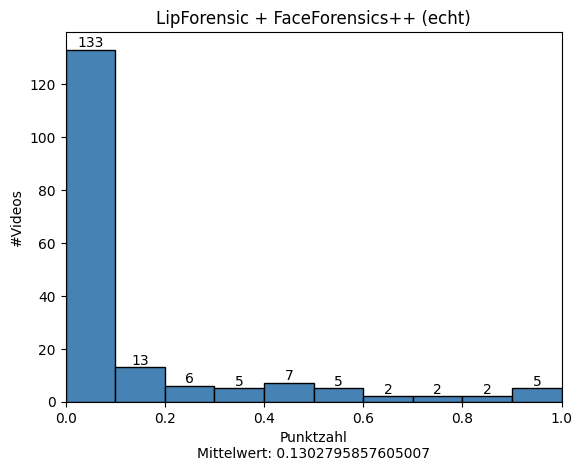

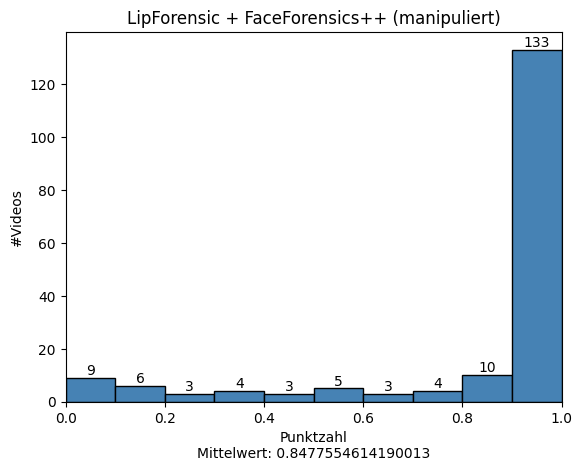

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(score_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'{net_model} + {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {score_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'{net_model} + {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(score_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(score_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(score_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(score_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

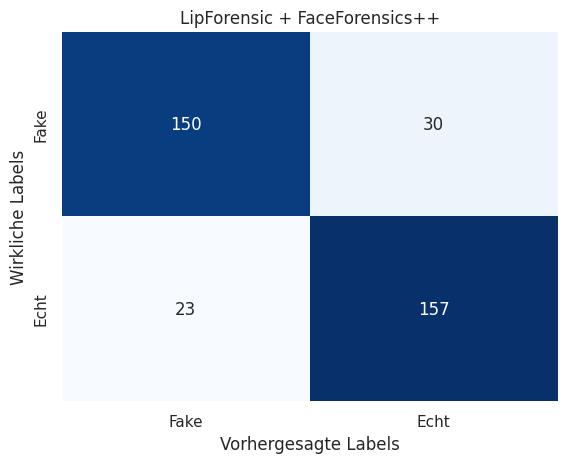

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

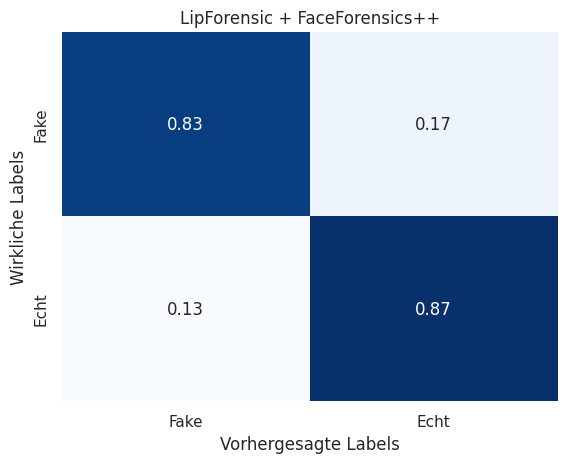

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()